In [63]:
# Installation der Bibliotheken
%pip install -q tensorflow scikit-learn pandas numpy matplotlib seaborn statsmodels xgboost


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xgboost as xgb

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from keras import layers

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use('fivethirtyeight')


In [65]:
# Daten von Kaggle herunterladen
!curl -L -o email-ctr-prediction.zip https://www.kaggle.com/api/v1/datasets/download/sk4467/email-ctr-prediction
!unzip -o email-ctr-prediction.zip train_data.csv

# Daten laden
df_raw = pd.read_csv('train_data.csv')
df_raw.head()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 59241  100 59241    0     0   139k      0 --:--:-- --:--:-- --:--:--  139k
Archive:  email-ctr-prediction.zip
  inflating: train_data.csv          


,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,...,0,0,0,0,0,0,0,0,14,0.10
1,2,3,54,2570,256,5,1,Morning,2,11,...,0,0,0,0,0,0,0,0,10,0.70
2,3,3,59,12801,16,5,1,Noon,2,11,...,1,0,1,0,0,0,0,0,16,0.00
3,4,3,74,11037,30,4,0,Evening,15,9,...,0,0,0,0,0,0,0,0,10,0.01
4,5,3,80,10011,27,5,1,Noon,6,26,...,0,0,1,0,0,0,0,0,14,0.14


In [66]:
# Struktur und Datentypen
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   campaign_id         1888 non-null   int64  
 1   sender              1888 non-null   int64  
 2   subject_len         1888 non-null   int64  
 3   body_len            1888 non-null   int64  
 4   mean_paragraph_len  1888 non-null   int64  
 5   day_of_week         1888 non-null   int64  
 6   is_weekend          1888 non-null   int64  
 7   times_of_day        1888 non-null   object 
 8   category            1888 non-null   int64  
 9   product             1888 non-null   int64  
 10  no_of_CTA           1888 non-null   int64  
 11  mean_CTA_len        1888 non-null   int64  
 12  is_image            1888 non-null   int64  
 13  is_personalised     1888 non-null   int64  
 14  is_quote            1888 non-null   int64  
 15  is_timer            1888 non-null   int64  
 16  is_emo

In [67]:
# Deskriptive Statistik
df_raw.describe()


,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,category,product,no_of_CTA,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
count,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,...,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00,1888.00
mean,944.50,4.40,86.25,14185.78,35.24,2.83,0.20,9.95,17.53,4.22,...,0.91,0.06,0.83,0.00,0.21,0.04,40.20,0.11,11.63,0.04
std,545.16,3.28,30.14,7327.62,28.14,1.76,0.40,5.30,12.37,4.63,...,0.87,0.23,1.03,0.00,0.61,0.20,553.96,0.32,2.95,0.08
min,1.00,0.00,9.00,23.00,4.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,472.75,3.00,69.00,9554.50,21.00,1.00,0.00,6.00,9.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,0.01
50%,944.50,3.00,83.00,12689.00,29.00,3.00,0.00,10.00,12.00,3.00,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,12.00,0.01
75%,1416.25,3.00,98.00,17351.50,40.00,4.00,0.00,15.00,27.25,5.00,...,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,12.00,0.04
max,1888.00,15.00,265.00,44491.00,286.00,6.00,1.00,15.00,43.00,49.00,...,6.00,1.00,6.00,0.00,6.00,1.00,14999.00,1.00,16.00,0.90


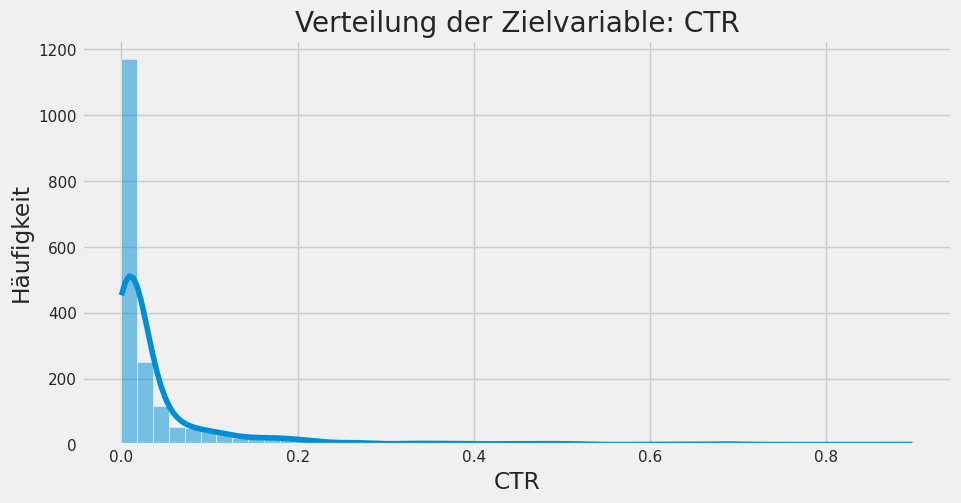

In [68]:
# Verteilung der Zielvariable
plt.figure(figsize=(10, 5))
sns.histplot(df_raw['click_rate'], bins=50, kde=True)
plt.xlabel('CTR')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Zielvariable: CTR')
plt.show()


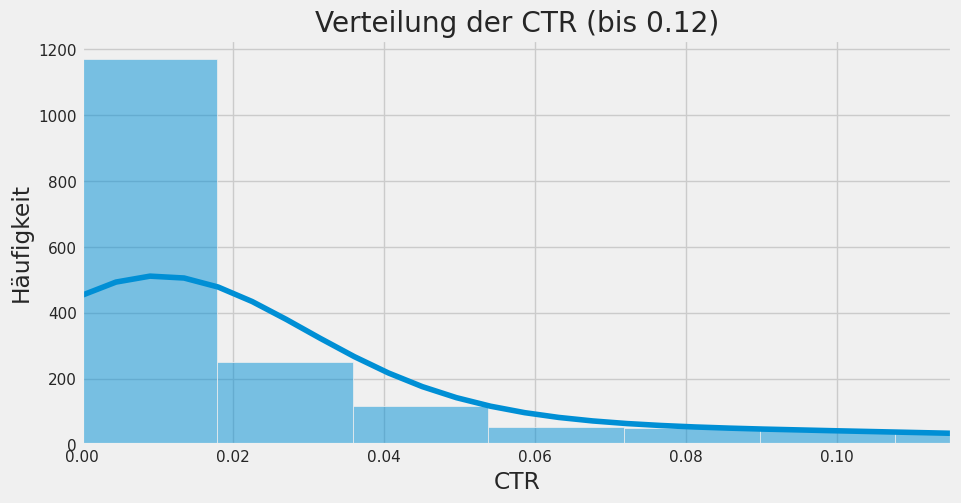

In [69]:
# Verteilung der Zielvariable (zugeschnitten auf 90. Perzentil)
upper_limit = df_raw['click_rate'].quantile(0.90)

plt.figure(figsize=(10, 5))
sns.histplot(df_raw['click_rate'], bins=50, kde=True)
plt.xlim(0, upper_limit)
plt.xlabel('CTR')
plt.ylabel('Häufigkeit')
plt.title(f'Verteilung der CTR (bis {upper_limit:.2f})')
plt.show()


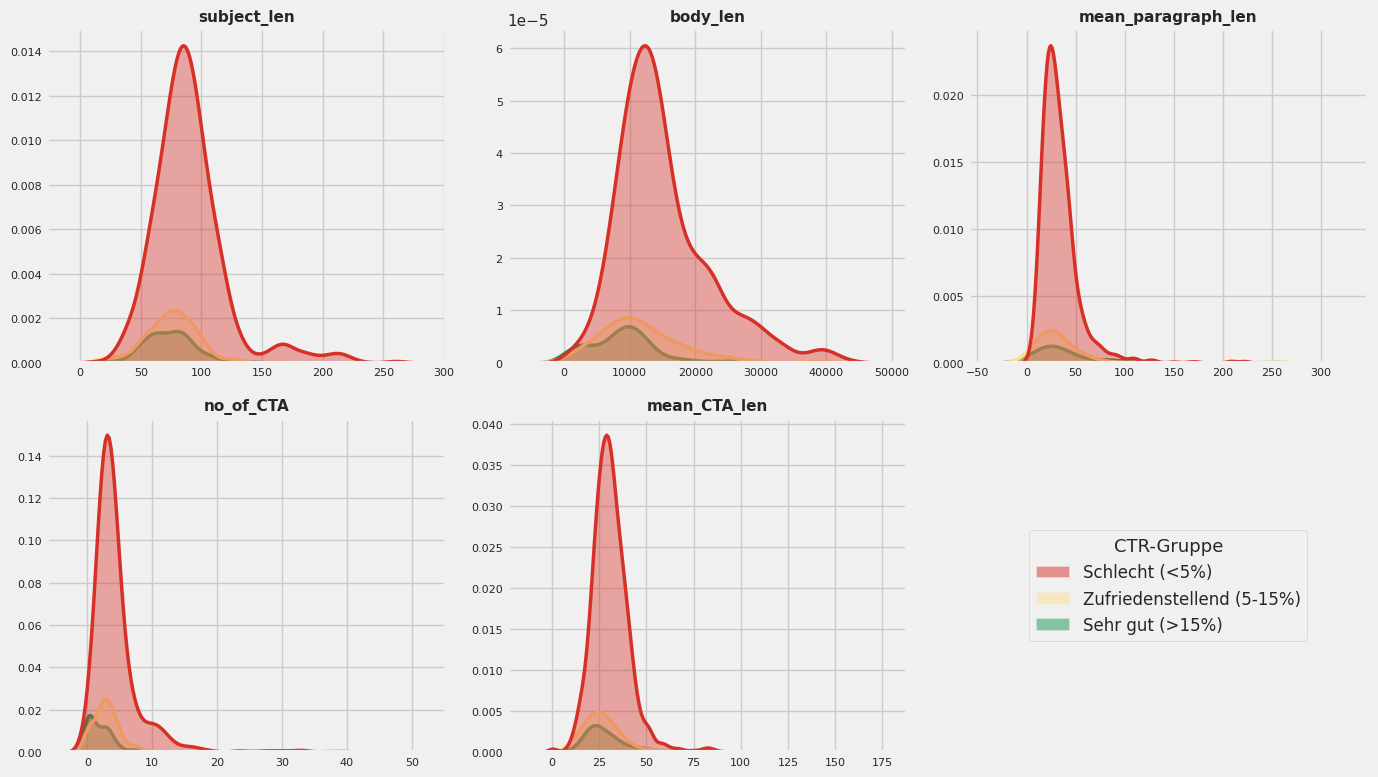

In [70]:
# Dichtefunktionen der kontinuierlichen Variablen nach CTR-Gruppen
# CTR-Gruppen: Schlecht (< 5%), Zufriedenstellend (5-15%), Sehr gut (> 15%)

df_raw['ctr_group'] = pd.cut(df_raw['click_rate'], 
                              bins=[0, 0.05, 0.15, float('inf')],
                              labels=['Schlecht (<5%)', 'Zufriedenstellend (5-15%)', 'Sehr gut (>15%)'])

continuous_features = ['subject_len', 'body_len', 'mean_paragraph_len', 
                       'no_of_CTA', 'mean_CTA_len']

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

colors = {'Schlecht (<5%)': '#d73027', 'Zufriedenstellend (5-15%)': '#fee08b', 'Sehr gut (>15%)': '#1a9850'}

# Zeichenreihenfolge: Rot hinten, Gelb Mitte, Grün vorne
hue_order = ['Schlecht (<5%)', 'Zufriedenstellend (5-15%)', 'Sehr gut (>15%)']

for i, col in enumerate(continuous_features):
    sns.kdeplot(data=df_raw, x=col, hue='ctr_group', hue_order=hue_order, ax=axes[i], 
                palette=colors, fill=True, alpha=0.4, linewidth=2.5)
    axes[i].set_title(col, fontsize=11, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='both', labelsize=8)
    if axes[i].get_legend():
        axes[i].get_legend().remove()

# Legende im leeren 6. Subplot-Bereich
axes[5].set_visible(True)
axes[5].axis('off')
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#d73027', alpha=0.5, label='Schlecht (<5%)'),
                   Patch(facecolor='#fee08b', alpha=0.5, label='Zufriedenstellend (5-15%)'),
                   Patch(facecolor='#1a9850', alpha=0.5, label='Sehr gut (>15%)')]
axes[5].legend(handles=legend_elements, loc='center', fontsize=12, title='CTR-Gruppe', 
               title_fontsize=13, frameon=True, fancybox=True)

plt.tight_layout()
plt.show()


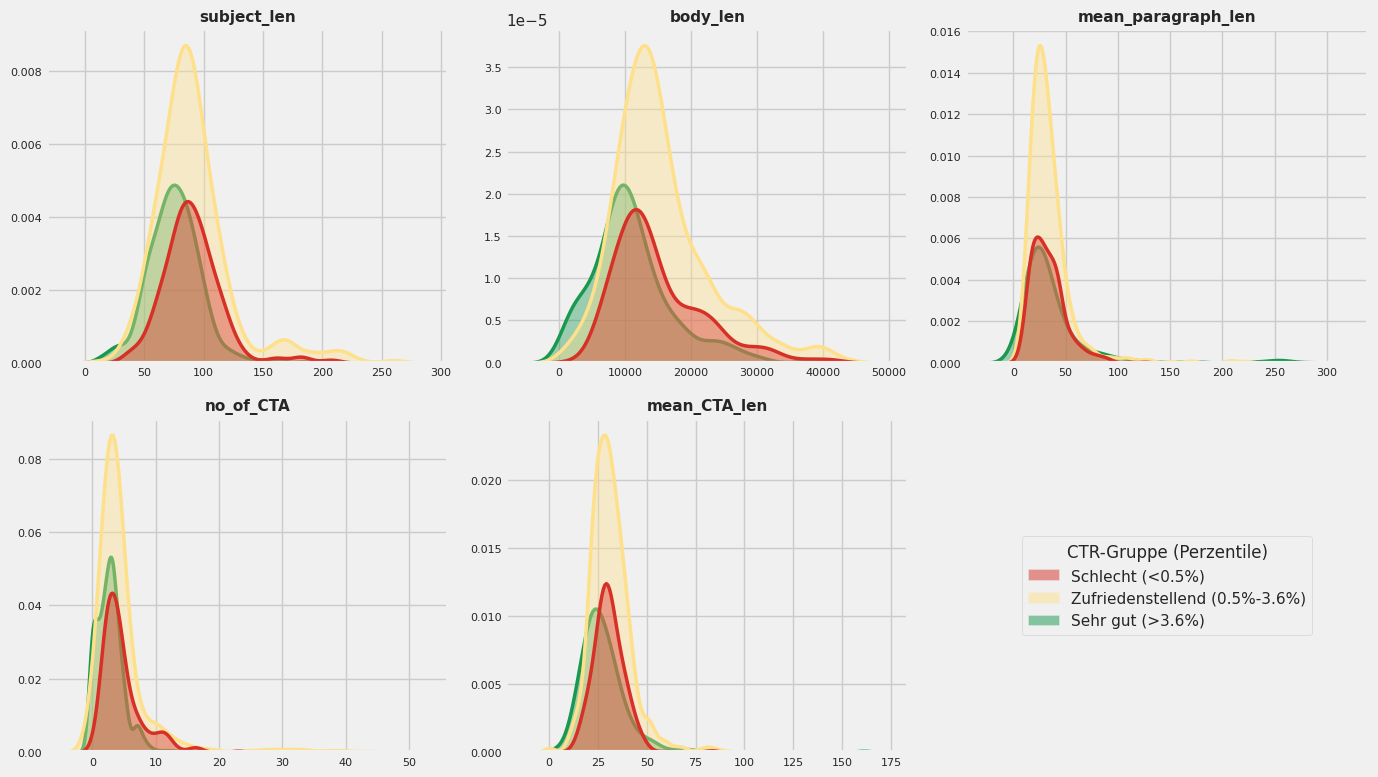

In [71]:
# Dichtefunktionen nach Perzentil-basierter CTR-Gruppierung
# Gruppen: Unteres Quartil (<25%), Mitte (25-75%), Oberes Quartil (>75%)

q25 = df_raw['click_rate'].quantile(0.25)
q75 = df_raw['click_rate'].quantile(0.75)

df_raw['ctr_group_pct'] = pd.cut(df_raw['click_rate'], 
                                  bins=[0, q25, q75, float('inf')],
                                  labels=[f'Schlecht (<{q25:.1%})', 
                                          f'Zufriedenstellend ({q25:.1%}-{q75:.1%})', 
                                          f'Sehr gut (>{q75:.1%})'])

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

colors_pct = {f'Schlecht (<{q25:.1%})': '#d73027', 
              f'Zufriedenstellend ({q25:.1%}-{q75:.1%})': '#fee08b', 
              f'Sehr gut (>{q75:.1%})': '#1a9850'}

hue_order_pct = [f'Schlecht (<{q25:.1%})', f'Zufriedenstellend ({q25:.1%}-{q75:.1%})', f'Sehr gut (>{q75:.1%})']

for i, col in enumerate(continuous_features):
    sns.kdeplot(data=df_raw, x=col, hue='ctr_group_pct', hue_order=hue_order_pct, ax=axes[i], 
                palette=colors_pct, fill=True, alpha=0.4, linewidth=2.5)
    axes[i].set_title(col, fontsize=11, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='both', labelsize=8)
    if axes[i].get_legend():
        axes[i].get_legend().remove()

# Legende im leeren 6. Subplot-Bereich
axes[5].set_visible(True)
axes[5].axis('off')
from matplotlib.patches import Patch
legend_elements_pct = [Patch(facecolor='#d73027', alpha=0.5, label=f'Schlecht (<{q25:.1%})'),
                       Patch(facecolor='#fee08b', alpha=0.5, label=f'Zufriedenstellend ({q25:.1%}-{q75:.1%})'),
                       Patch(facecolor='#1a9850', alpha=0.5, label=f'Sehr gut (>{q75:.1%})')]
axes[5].legend(handles=legend_elements_pct, loc='center', fontsize=11, title='CTR-Gruppe (Perzentile)', 
               title_fontsize=12, frameon=True, fancybox=True)

plt.tight_layout()
plt.show()


In [72]:
# Prüfung auf fehlende Werte pro Spalte
df_raw.isnull().sum()


,0
campaign_id,0
sender,0
subject_len,0
body_len,0
mean_paragraph_len,0
day_of_week,0
is_weekend,0
times_of_day,0
category,0
product,0


In [73]:
# Ausreißer-Erkennung mit IQR-Methode
def count_outliers_iqr(df, factor=1.5):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outlier_counts = {}
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_counts[col] = outliers
    
    return pd.Series(outlier_counts).sort_values(ascending=False)

count_outliers_iqr(df_raw)


,0
target_audience,719
is_weekend,377
sender,329
click_rate,268
is_emoticons,262
is_urgency,212
no_of_CTA,141
is_quote,138
mean_paragraph_len,126
is_personalised,107


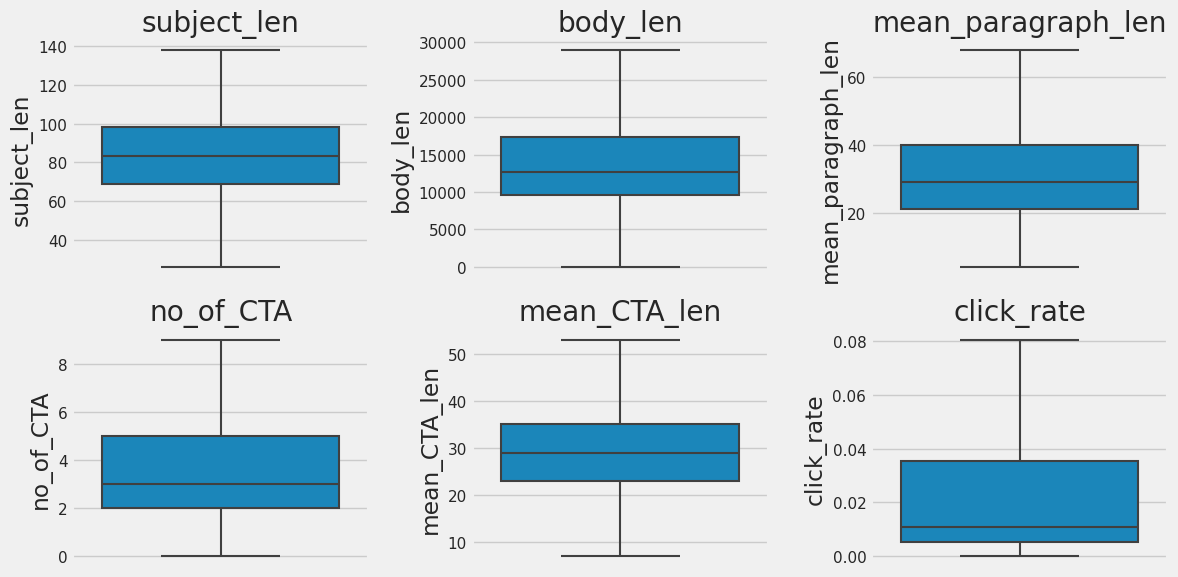

In [74]:
# Boxplots der kontinuierlichen Variablen (Ausreißer-Punkte ausgeblendet für bessere Lesbarkeit)
continuous_vars = ['subject_len', 'body_len', 'mean_paragraph_len', 
                   'no_of_CTA', 'mean_CTA_len', 'click_rate']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(continuous_vars):
    sns.boxplot(y=df_raw[col], ax=axes[i], showfliers=False, linewidth=1.5)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


In [75]:
# Statistische Kennzahlen für Boxplots der kontinuierlichen Variablen
continuous_vars = ['subject_len', 'body_len', 'mean_paragraph_len', 
                   'no_of_CTA', 'mean_CTA_len', 'click_rate']

boxplot_stats = []

for col in continuous_vars:
    q1 = df_raw[col].quantile(0.25)
    median = df_raw[col].quantile(0.50)
    q3 = df_raw[col].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = max(df_raw[col].min(), q1 - 1.5 * iqr)
    upper_whisker = min(df_raw[col].max(), q3 + 1.5 * iqr)
    
    boxplot_stats.append({
        'Variable': col,
        'Min': df_raw[col].min(),
        'Q1 (25%)': q1,
        'Median': median,
        'Q3 (75%)': q3,
        'Max': df_raw[col].max(),
        'IQR': iqr,
        'Untere Grenze': lower_whisker,
        'Obere Grenze': upper_whisker
    })

boxplot_df = pd.DataFrame(boxplot_stats)
boxplot_df.round(2)


,Variable,Min,Q1 (25%),Median,Q3 (75%),Max,IQR,Untere Grenze,Obere Grenze
0,subject_len,9.00,69.00,83.00,98.00,265.00,29.00,25.50,141.50
1,body_len,23.00,9554.50,12689.00,17351.50,44491.00,7797.00,23.00,29047.00
2,mean_paragraph_len,4.00,21.00,29.00,40.00,286.00,19.00,4.00,68.50
3,no_of_CTA,0.00,2.00,3.00,5.00,49.00,3.00,0.00,9.50
4,mean_CTA_len,0.00,23.00,29.00,35.00,162.00,12.00,5.00,53.00
5,click_rate,0.00,0.01,0.01,0.04,0.90,0.03,0.00,0.08


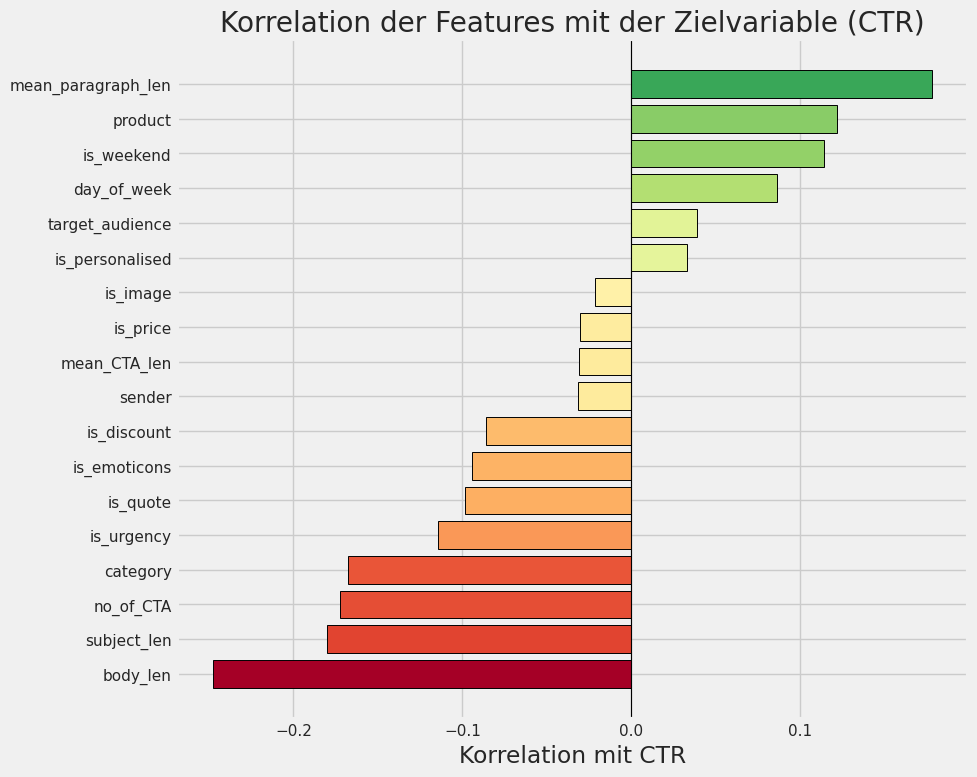

In [76]:
# Korrelation aller relevanten Features mit der Zielvariable (CTR)
# Ausgeschlossen: campaign_id (ID) und is_timer (konstant, alle Werte = 0)

exclude_cols = ['campaign_id', 'is_timer', 'click_rate']
feature_cols = [col for col in df_raw.select_dtypes(include=[np.number]).columns if col not in exclude_cols]

corr_with_target = df_raw[feature_cols].corrwith(df_raw['click_rate']).sort_values()

cmap = plt.cm.RdYlGn
max_abs = max(abs(corr_with_target.min()), abs(corr_with_target.max()))
norm = plt.Normalize(vmin=-max_abs, vmax=max_abs)
colors = [cmap(norm(val)) for val in corr_with_target]

plt.figure(figsize=(10, 8))
plt.barh(corr_with_target.index, corr_with_target.values, color=colors, edgecolor='black', linewidth=0.7)
plt.xlabel('Korrelation mit CTR')
plt.title('Korrelation der Features mit der Zielvariable (CTR)')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


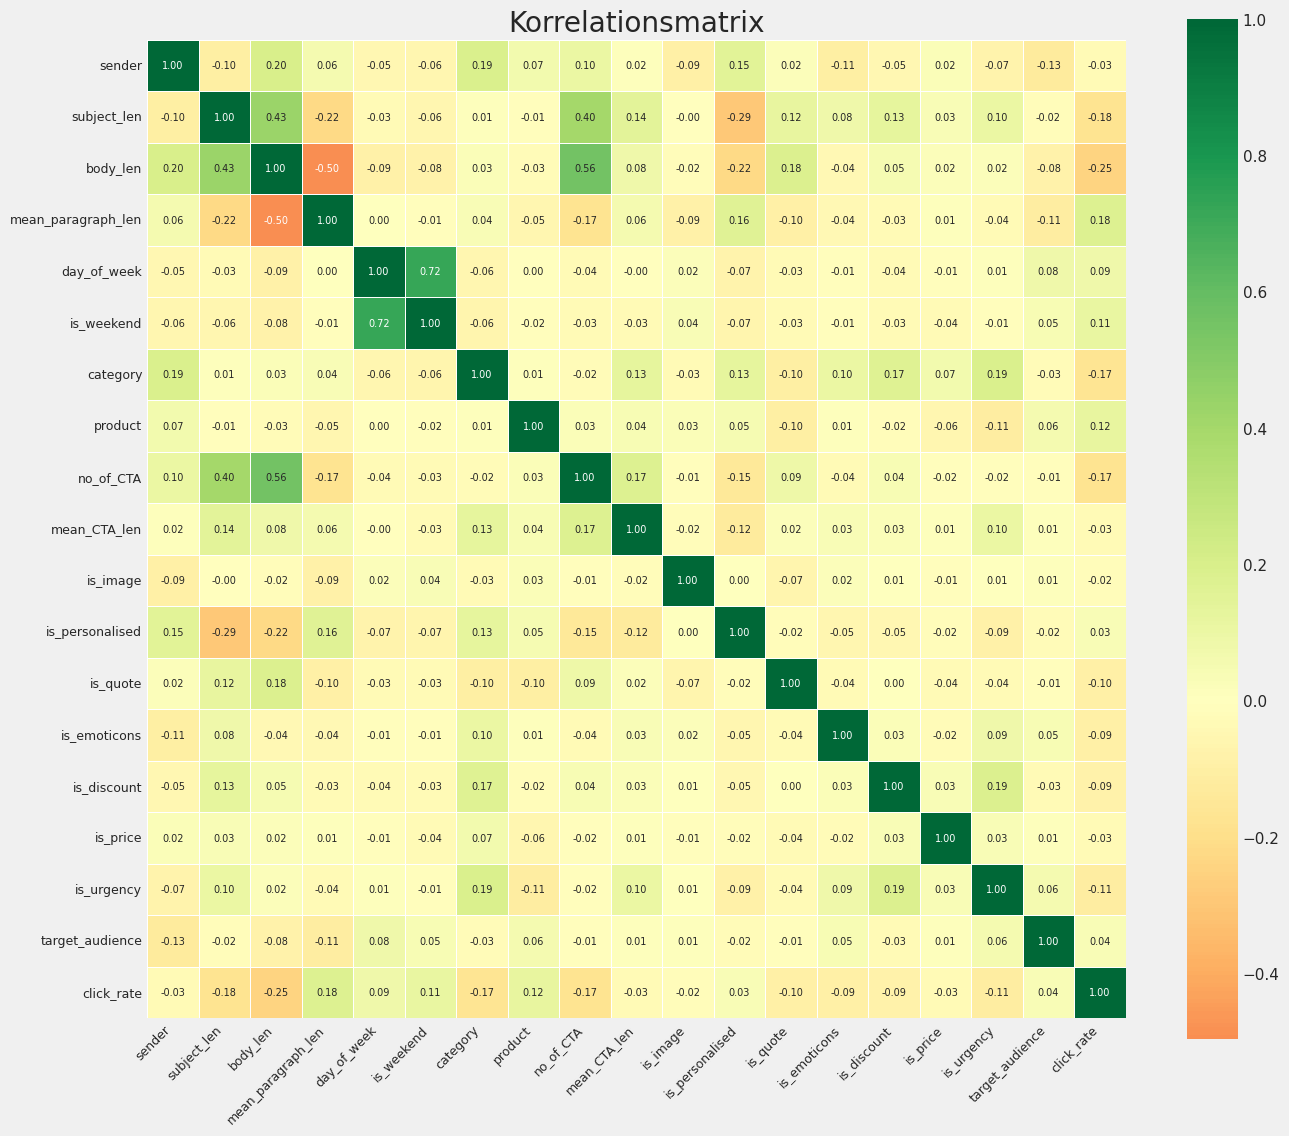

In [77]:
# Reduzierte Korrelationsmatrix
# Ausgeschlossen: campaign_id (ID) und is_timer (konstant, alle Werte = 0)
exclude_cols = ['campaign_id', 'is_timer']
relevant_cols = [col for col in df_raw.select_dtypes(include=[np.number]).columns if col not in exclude_cols]

corr_matrix = df_raw[relevant_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=0.5, annot_kws={'size': 7})
plt.title('Korrelationsmatrix')
plt.xticks(fontsize=9, rotation=45, ha='right')
plt.yticks(fontsize=9, rotation=0)
plt.tight_layout()
plt.show()


In [78]:
# Variance Inflation Factor (VIF) zur Multikollinearitätsprüfung
# Ausgeschlossen: campaign_id (ID), is_timer (konstant), click_rate (Zielvariable)
# Auch kategorische/nicht-numerische Spalten werden ausgeschlossen

exclude_cols = ['campaign_id', 'is_timer', 'click_rate', 'ctr_group', 'ctr_group_pct', 'times_of_day']
vif_features = [col for col in df_raw.columns if col not in exclude_cols and df_raw[col].dtype in ['int64', 'float64']]

vif_data = df_raw[vif_features].dropna()

vif_results = pd.DataFrame()
vif_results['Feature'] = vif_features
vif_results['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_features))]
vif_results = vif_results.sort_values('VIF', ascending=False).reset_index(drop=True)

vif_results


,Feature,VIF
0,subject_len,11.65
1,target_audience,11.04
2,body_len,9.63
3,mean_CTA_len,7.81
4,day_of_week,7.21
5,category,5.22
6,sender,3.38
7,mean_paragraph_len,3.12
8,product,3.09
9,no_of_CTA,2.81


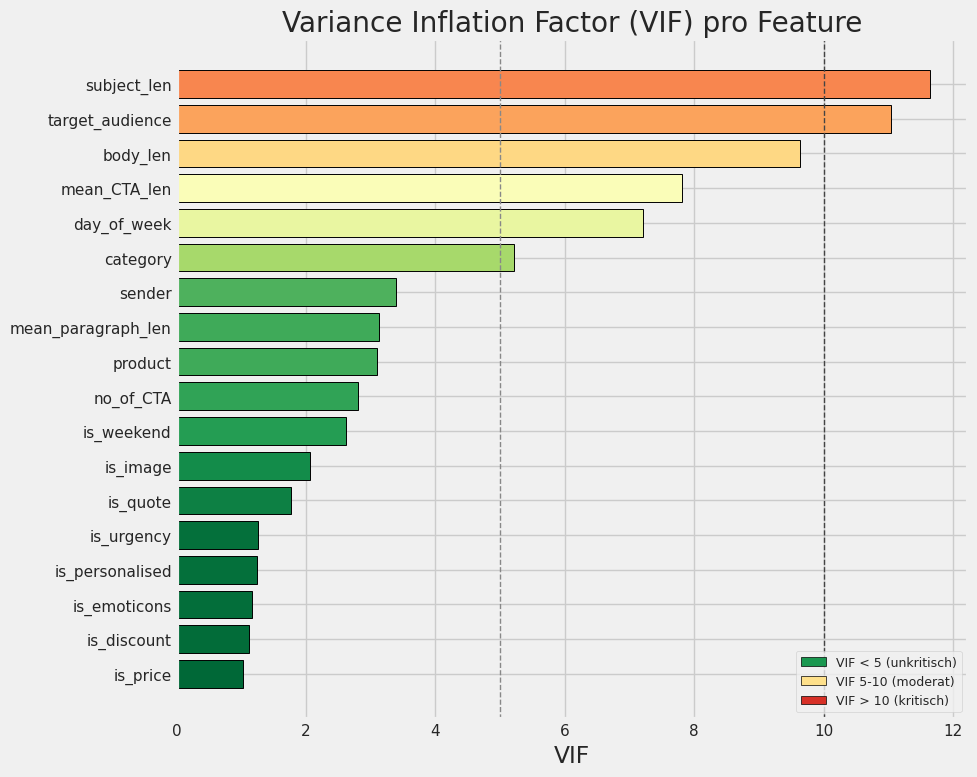

In [79]:
# VIF-Visualisierung
vif_sorted = vif_results.sort_values('VIF', ascending=True)

plt.figure(figsize=(10, 8))

cmap = plt.cm.RdYlGn_r
norm = plt.Normalize(vmin=1, vmax=max(15, vif_sorted['VIF'].max()))
colors = [cmap(norm(val)) for val in vif_sorted['VIF']]

plt.barh(vif_sorted['Feature'], vif_sorted['VIF'], color=colors, edgecolor='black', linewidth=0.7)

plt.xlabel('VIF')
plt.title('Variance Inflation Factor (VIF) pro Feature')

# Referenzlinien für VIF-Schwellenwerte
plt.axvline(x=5, color='#888888', linestyle='--', linewidth=1, label='VIF = 5')
plt.axvline(x=10, color='#444444', linestyle='--', linewidth=1, label='VIF = 10')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#1a9850', edgecolor='black', label='VIF < 5 (unkritisch)'),
                   Patch(facecolor='#fee08b', edgecolor='black', label='VIF 5-10 (moderat)'),
                   Patch(facecolor='#d73027', edgecolor='black', label='VIF > 10 (kritisch)')]
plt.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()


In [80]:
# Analyse der Features mit hohem VIF (> 10)
high_vif_features = vif_results[vif_results['VIF'] > 10]['Feature'].tolist()

if len(high_vif_features) > 0:
    print(f"Features mit VIF > 10: {high_vif_features}\n")
    
    # Korrelation dieser Features untereinander
    print("Korrelation untereinander:")
    print(df_raw[high_vif_features].corr().round(2))
    print()
    
    # Korrelation mit CTR
    print("Korrelation mit CTR:")
    for feat in high_vif_features:
        corr = df_raw[feat].corr(df_raw['click_rate'])
        print(f"  {feat}: {corr:.4f}")
else:
    print("Keine Features mit VIF > 10 gefunden!")


Features mit VIF > 10: ['subject_len', 'target_audience']

Korrelation untereinander:
                 subject_len  target_audience
subject_len             1.00            -0.02
target_audience        -0.02             1.00

Korrelation mit CTR:
  subject_len: -0.1801
  target_audience: 0.0387


In [81]:
# Zyklisches Encoding für day_of_week (Sinus/Cosinus-Transformation)
df = df_raw.copy()

df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df = df.drop(columns=['day_of_week'])

df[['day_sin', 'day_cos']].head(10)


,day_sin,day_cos
0,-0.97,-0.22
1,-0.97,-0.22
2,-0.97,-0.22
3,-0.43,-0.90
4,-0.97,-0.22
5,-0.43,-0.90
6,-0.43,-0.90
7,-0.43,-0.90
8,-0.43,-0.90
9,0.43,-0.90


In [82]:
# One-Hot-Encoding für times_of_day
df = pd.get_dummies(df, columns=['times_of_day'], prefix='time', dtype=int)

df.filter(like='time_').head(10)


,time_Evening,time_Morning,time_Noon
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,0,1
5,1,0,0
6,1,0,0
7,0,0,1
8,0,0,1
9,1,0,0


In [83]:
# Datenbereinigung: Entfernen irrelevanter Spalten
# campaign_id: reine ID-Variable ohne Vorhersagekraft
# is_timer: konstante Variable (alle Werte = 0)
# ctr_group, ctr_group_pct: temporäre Spalten für Visualisierung

drop_cols = ['campaign_id', 'is_timer', 'ctr_group', 'ctr_group_pct']
df = df.drop(columns=drop_cols)

print(f"Entfernte Spalten: {drop_cols}")
print(f"Verbleibende Spalten: {df.shape[1]}")
print(f"Datensatzgröße: {df.shape[0]} Zeilen")
df.columns.tolist()


Entfernte Spalten: ['campaign_id', 'is_timer', 'ctr_group', 'ctr_group_pct']
Verbleibende Spalten: 23
Datensatzgröße: 1888 Zeilen


['sender',
 'subject_len',
 'body_len',
 'mean_paragraph_len',
 'is_weekend',
 'category',
 'product',
 'no_of_CTA',
 'mean_CTA_len',
 'is_image',
 'is_personalised',
 'is_quote',
 'is_emoticons',
 'is_discount',
 'is_price',
 'is_urgency',
 'target_audience',
 'click_rate',
 'day_sin',
 'day_cos',
 'time_Evening',
 'time_Morning',
 'time_Noon']

In [84]:
# Feature Engineering: Neue Features aus bestehenden Daten ableiten
# 1. subject_body_ratio: Verhältnis von Betreff- zu Textlänge
df['subject_body_ratio'] = df['subject_len'] / df['body_len']

# 2. total_cta: Gesamtlänge aller Call-to-Actions
df['total_cta'] = df['no_of_CTA'] * df['mean_CTA_len']

# 3. paragraphs: Geschätzte Anzahl der Absätze
df['paragraphs'] = df['body_len'] / df['mean_paragraph_len']

print("Neue Features erstellt:")
print(f"  subject_body_ratio: min={df['subject_body_ratio'].min():.3f}, max={df['subject_body_ratio'].max():.3f}")
print(f"  total_cta:          min={df['total_cta'].min():.1f}, max={df['total_cta'].max():.1f}")
print(f"  paragraphs:         min={df['paragraphs'].min():.1f}, max={df['paragraphs'].max():.1f}")
print(f"\nAnzahl Features: {df.shape[1] - 1} (ohne Zielvariable)")


Neue Features erstellt:
  subject_body_ratio: min=0.001, max=2.348
  total_cta:          min=0.0, max=3237.0
  paragraphs:         min=5.7, max=6982.0

Anzahl Features: 25 (ohne Zielvariable)


In [85]:
# Train/Test Split (80/20)
# Features und Zielvariable trennen
X = df.drop(columns=['click_rate'])
y = df['click_rate']

# Aufteilung: 80% Entwicklungs-Pool, 20% Hold-out Test-Set
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Entwicklungs-Pool: {X_dev.shape[0]} Datensätze ({X_dev.shape[0]/len(df)*100:.1f}%)")
print(f"Hold-out Test-Set: {X_test.shape[0]} Datensätze ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"Anzahl Features: {X_dev.shape[1]}")


Entwicklungs-Pool: 1510 Datensätze (80.0%)
Hold-out Test-Set: 378 Datensätze (20.0%)
Anzahl Features: 25


In [86]:
# Skalierung erfolgt innerhalb der Cross-Validation pro Fold

print(f"X_dev: {X_dev.shape}")
print(f"X_test: {X_test.shape}")


X_dev: (1510, 25)
X_test: (378, 25)


In [87]:
# MLP-Modell Definition
def create_mlp(input_dim, hidden1=256, hidden2=128):
    """
    Erstellt ein Multi-Layer Perceptron für Regression.
    
    Args:
        input_dim: Anzahl der Input-Features
        hidden1: Neuronen in erster Hidden-Layer (default: 256)
        hidden2: Neuronen in zweiter Hidden-Layer (default: 128)
    
    Returns:
        Kompiliertes Keras-Modell
    """
    model = keras.Sequential([
        layers.Dense(hidden1, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.2),  # Regularisierung gegen Overfitting
        layers.Dense(hidden2, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Modell-Architektur anzeigen (mit korrekter Input-Dimension)
input_dim = X_dev.shape[1]  # Anzahl Features
print(f"Input-Dimension: {input_dim} Features")
print("\nModell-Architektur:")
demo_model = create_mlp(input_dim)
demo_model.summary()


Input-Dimension: 25 Features

Modell-Architektur:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 256)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,681 (155.00 KB)

 Trainable params: 39,681 (155.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 5-Fold Cross-Validation (MLP ohne Log-Transformation)

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_results = []
fold_histories = []

print("5-Fold CV (MLP)\n")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_dev), 1):
    X_train_fold = X_dev.iloc[train_idx]
    X_val_fold = X_dev.iloc[val_idx]
    y_train_fold = y_dev.iloc[train_idx]
    y_val_fold = y_dev.iloc[val_idx]
    
    scaler_fold = StandardScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_scaled = scaler_fold.transform(X_val_fold)
    
    model_fold = create_mlp(X_train_scaled.shape[1])
    history_fold = model_fold.fit(
        X_train_scaled, y_train_fold,
        validation_data=(X_val_scaled, y_val_fold),
        epochs=100, batch_size=32, verbose=0
    )
    fold_histories.append(history_fold)
    
    y_pred_fold = model_fold.predict(X_val_scaled, verbose=0).flatten()
    
    fold_mae = mean_absolute_error(y_val_fold, y_pred_fold)
    fold_mse = mean_squared_error(y_val_fold, y_pred_fold)
    fold_r2 = r2_score(y_val_fold, y_pred_fold)
    
    cv_results.append({
        'fold': fold, 'mae': fold_mae, 'mse': fold_mse, 'r2': fold_r2,
        'train_size': len(train_idx), 'val_size': len(val_idx)
    })
    print(f"Fold {fold}: MAE={fold_mae:.4f}, MSE={fold_mse:.6f}, R2={fold_r2:.4f}")

cv_df = pd.DataFrame(cv_results)
print(f"\nDurchschnitt: MAE={cv_df['mae'].mean():.4f} +/- {cv_df['mae'].std():.4f}")


5-Fold CV (MLP)

Fold 1: MAE=0.0306, MSE=0.004181, R2=0.2143
Fold 2: MAE=0.0343, MSE=0.005247, R2=0.1282
Fold 3: MAE=0.0341, MSE=0.006298, R2=0.4681
Fold 4: MAE=0.0309, MSE=0.004789, R2=0.4101
Fold 5: MAE=0.0328, MSE=0.004560, R2=0.3773

Durchschnitt: MAE=0.0325 +/- 0.0018


In [ ]:
# Finale Evaluation auf Hold-out Test-Set

final_scaler = StandardScaler()
X_dev_scaled_final = final_scaler.fit_transform(X_dev)
X_test_scaled_final = final_scaler.transform(X_test)

final_model = create_mlp(X_dev_scaled_final.shape[1])
final_history = final_model.fit(
    X_dev_scaled_final, y_dev,
    epochs=100, batch_size=32, validation_split=0.1, verbose=0
)

y_test_pred = final_model.predict(X_test_scaled_final, verbose=0).flatten()

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test-Set Metriken:")
print(f"  MAE: {test_mae:.4f}")
print(f"  MSE: {test_mse:.6f}")
print(f"  R2:  {test_r2:.4f}")
print(f"\nCV MAE: {cv_df['mae'].mean():.4f}, Test MAE: {test_mae:.4f}")


Test-Set Metriken:
  MAE: 0.0285
  MSE: 0.003817
  R2:  0.1373

CV MAE: 0.0325, Test MAE: 0.0285


In [ ]:
# Baseline Vergleich
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

baseline_naive = DummyRegressor(strategy='mean')
baseline_naive.fit(X_dev, y_dev)
y_baseline_pred = baseline_naive.predict(X_test)
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)

lr_baseline = LinearRegression()
lr_baseline.fit(X_dev_scaled_final, y_dev)
y_lr_pred = lr_baseline.predict(X_test_scaled_final)
lr_mae = mean_absolute_error(y_test, y_lr_pred)

improvement_vs_naive = ((baseline_mae - test_mae) / baseline_mae) * 100

print("Test-Set MAE:")
print(f"  Naive Baseline: {baseline_mae:.4f}")
print(f"  Lin. Regression: {lr_mae:.4f}")
print(f"  MLP: {test_mae:.4f}")
print(f"\nVerbesserung vs. Baseline: {improvement_vs_naive:+.1f}%")


Test-Set MAE:
  Naive Baseline: 0.0439
  Lin. Regression: 0.0470
  MLP: 0.0285

Verbesserung vs. Baseline: +35.2%


In [ ]:
# Kompatibilitäts-Variablen
X_dev_scaled = X_dev_scaled_final
X_test_scaled = X_test_scaled_final
scaler = final_scaler
model = final_model
history = final_history


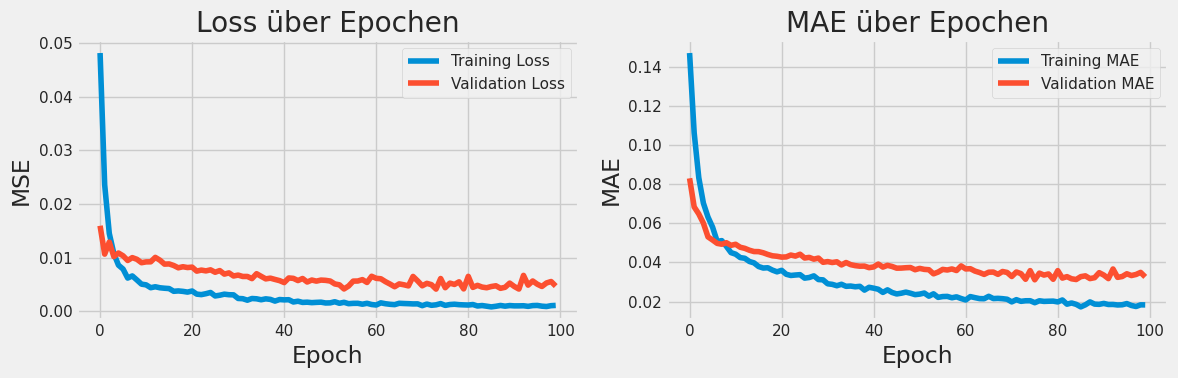


Finale Werte:
  Training Loss (MSE): 0.001106
  Validation Loss (MSE): 0.004706
  Training MAE: 0.018265
  Validation MAE: 0.032585


In [ ]:
# Trainingshistorie visualisieren
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].set_title('Loss über Epochen')
axes[0].legend()

# MAE
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE über Epochen')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nFinale Werte:")
print(f"  Training Loss (MSE): {history.history['loss'][-1]:.6f}")
print(f"  Validation Loss (MSE): {history.history['val_loss'][-1]:.6f}")
print(f"  Training MAE: {history.history['mae'][-1]:.6f}")
print(f"  Validation MAE: {history.history['val_mae'][-1]:.6f}")


In [ ]:
# Log-Transformation der Zielvariable und Initialisierung des Results-Registry

EPSILON = 0.001

results_registry = {}

y_dev_transformed = np.log(y_dev + EPSILON)
y_test_transformed = np.log(y_test + EPSILON)

def inverse_transform_predictions(y_pred_log, epsilon=EPSILON):
    """Rücktransformation: exp(y) - epsilon, geclippt auf [0, ∞)"""
    y_pred = np.exp(y_pred_log) - epsilon
    return np.clip(y_pred, 0, None)

skew_original = y_dev.skew()
skew_transformed = y_dev_transformed.skew()

print(f"Log-Transformation: log(y + {EPSILON})")
print(f"Schiefe vorher:  {skew_original:.4f}")
print(f"Schiefe nachher: {skew_transformed:.4f} (Reduktion: {((skew_original - skew_transformed) / skew_original * 100):.1f}%)")


Log-Transformation: log(y + 0.001)
Schiefe vorher:  4.3331
Schiefe nachher: 0.6004 (Reduktion: 86.1%)


In [ ]:
# MLP (256-128) mit 5-Fold Cross-Validation

print("MLP (256-128) - 5-Fold CV\n")

kfold_mlp = KFold(n_splits=5, shuffle=True, random_state=SEED)
mlp_log_results = []

for fold, (train_idx, val_idx) in enumerate(kfold_mlp.split(X_dev), 1):
    X_train_fold = X_dev.iloc[train_idx]
    X_val_fold = X_dev.iloc[val_idx]
    y_train_fold = y_dev_transformed.iloc[train_idx]
    y_val_fold = y_dev.iloc[val_idx]
    
    # Scaler pro Fold nur auf Train-Daten fitten
    scaler_fold = StandardScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_scaled = scaler_fold.transform(X_val_fold)
    
    model_fold = create_mlp(X_train_scaled.shape[1])
    model_fold.fit(X_train_scaled, y_train_fold, epochs=100, batch_size=32, verbose=0)
    
    y_pred_log = model_fold.predict(X_val_scaled, verbose=0).flatten()
    y_pred = inverse_transform_predictions(y_pred_log)
    
    fold_mae = mean_absolute_error(y_val_fold, y_pred)
    fold_mse = mean_squared_error(y_val_fold, y_pred)
    
    mlp_log_results.append({'fold': fold, 'mae': fold_mae, 'mse': fold_mse})
    print(f"Fold {fold}/5: MAE = {fold_mae:.4f} ({fold_mae*100:.2f} PP)")

mlp_mae_mean = np.mean([r['mae'] for r in mlp_log_results])
mlp_mae_std = np.std([r['mae'] for r in mlp_log_results])
mlp_mse_mean = np.mean([r['mse'] for r in mlp_log_results])

results_registry['MLP (256-128)'] = {
    'mae_mean': mlp_mae_mean,
    'mae_std': mlp_mae_std,
    'mse_mean': mlp_mse_mean,
    'fold_results': mlp_log_results
}

print(f"\nDurchschnitt: MAE = {mlp_mae_mean:.4f} ± {mlp_mae_std:.4f} ({mlp_mae_mean*100:.2f} PP)")


MLP (256-128) - 5-Fold CV

Fold 1/5: MAE = 0.0301 (3.01 PP)
Fold 2/5: MAE = 0.0333 (3.33 PP)
Fold 3/5: MAE = 0.0340 (3.40 PP)
Fold 4/5: MAE = 0.0313 (3.13 PP)
Fold 5/5: MAE = 0.0313 (3.13 PP)

Durchschnitt: MAE = 0.0320 ± 0.0014 (3.20 PP)


In [ ]:
# Random Forest mit 5-Fold Cross-Validation
from sklearn.ensemble import RandomForestRegressor

print("Random Forest (100 Bäume) - 5-Fold CV\n")

rf_results = []

for fold, (train_idx, val_idx) in enumerate(kfold_mlp.split(X_dev), 1):
    X_train_fold = X_dev.iloc[train_idx]
    X_val_fold = X_dev.iloc[val_idx]
    y_train_fold = y_dev_transformed.iloc[train_idx]
    y_val_fold = y_dev.iloc[val_idx]
    
    scaler_fold = StandardScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_scaled = scaler_fold.transform(X_val_fold)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf.fit(X_train_scaled, y_train_fold)
    
    y_pred_log = rf.predict(X_val_scaled)
    y_pred = inverse_transform_predictions(y_pred_log)
    
    fold_mae = mean_absolute_error(y_val_fold, y_pred)
    fold_mse = mean_squared_error(y_val_fold, y_pred)
    
    rf_results.append({'fold': fold, 'mae': fold_mae, 'mse': fold_mse})
    print(f"Fold {fold}/5: MAE = {fold_mae:.4f} ({fold_mae*100:.2f} PP)")

rf_mae_mean = np.mean([r['mae'] for r in rf_results])
rf_mae_std = np.std([r['mae'] for r in rf_results])
rf_mse_mean = np.mean([r['mse'] for r in rf_results])

results_registry['Random Forest'] = {
    'mae_mean': rf_mae_mean,
    'mae_std': rf_mae_std,
    'mse_mean': rf_mse_mean,
    'fold_results': rf_results
}

print(f"\nDurchschnitt: MAE = {rf_mae_mean:.4f} ± {rf_mae_std:.4f} ({rf_mae_mean*100:.2f} PP)")


Random Forest (100 Bäume) - 5-Fold CV

Fold 1/5: MAE = 0.0264 (2.64 PP)
Fold 2/5: MAE = 0.0267 (2.67 PP)
Fold 3/5: MAE = 0.0335 (3.35 PP)
Fold 4/5: MAE = 0.0306 (3.06 PP)
Fold 5/5: MAE = 0.0278 (2.78 PP)

Durchschnitt: MAE = 0.0290 ± 0.0027 (2.90 PP)


In [ ]:
# XGBoost mit 5-Fold Cross-Validation

print("XGBoost (500 Bäume, LR=0.1, depth=6) - 5-Fold CV\n")

xgb_results = []

for fold, (train_idx, val_idx) in enumerate(kfold_mlp.split(X_dev), 1):
    X_train_fold = X_dev.iloc[train_idx]
    X_val_fold = X_dev.iloc[val_idx]
    y_train_fold = y_dev_transformed.iloc[train_idx]
    y_val_fold = y_dev.iloc[val_idx]
    
    scaler_fold = StandardScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_scaled = scaler_fold.transform(X_val_fold)
    
    xgb_model = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.1, max_depth=6,
        random_state=SEED, n_jobs=-1, verbosity=0
    )
    xgb_model.fit(X_train_scaled, y_train_fold)
    
    y_pred_log = xgb_model.predict(X_val_scaled)
    y_pred = inverse_transform_predictions(y_pred_log)
    
    fold_mae = mean_absolute_error(y_val_fold, y_pred)
    fold_mse = mean_squared_error(y_val_fold, y_pred)
    
    xgb_results.append({'fold': fold, 'mae': fold_mae, 'mse': fold_mse})
    print(f"Fold {fold}/5: MAE = {fold_mae:.4f} ({fold_mae*100:.2f} PP)")

xgb_mae_mean = np.mean([r['mae'] for r in xgb_results])
xgb_mae_std = np.std([r['mae'] for r in xgb_results])
xgb_mse_mean = np.mean([r['mse'] for r in xgb_results])

results_registry['XGBoost'] = {
    'mae_mean': xgb_mae_mean,
    'mae_std': xgb_mae_std,
    'mse_mean': xgb_mse_mean,
    'fold_results': xgb_results
}

print(f"\nDurchschnitt: MAE = {xgb_mae_mean:.4f} ± {xgb_mae_std:.4f} ({xgb_mae_mean*100:.2f} PP)")


XGBoost (500 Bäume, LR=0.1, depth=6) - 5-Fold CV

Fold 1/5: MAE = 0.0254 (2.54 PP)
Fold 2/5: MAE = 0.0262 (2.62 PP)
Fold 3/5: MAE = 0.0313 (3.13 PP)
Fold 4/5: MAE = 0.0287 (2.87 PP)
Fold 5/5: MAE = 0.0291 (2.91 PP)

Durchschnitt: MAE = 0.0281 ± 0.0021 (2.81 PP)


In [ ]:
# Baseline-Modelle mit 5-Fold Cross-Validation
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

print("Baseline-Modelle - 5-Fold CV\n")

# Naive Baseline (Mittelwert)
print("Naive Baseline (Mittelwert)")
naive_results = []

for fold, (train_idx, val_idx) in enumerate(kfold_mlp.split(X_dev), 1):
    y_train_fold = y_dev.iloc[train_idx]
    y_val_fold = y_dev.iloc[val_idx]
    
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(X_dev.iloc[train_idx], y_train_fold)
    y_pred = dummy.predict(X_dev.iloc[val_idx])
    
    fold_mae = mean_absolute_error(y_val_fold, y_pred)
    naive_results.append({'fold': fold, 'mae': fold_mae})

naive_mae_mean = np.mean([r['mae'] for r in naive_results])
naive_mae_std = np.std([r['mae'] for r in naive_results])

results_registry['Naive (Mittelwert)'] = {
    'mae_mean': naive_mae_mean,
    'mae_std': naive_mae_std,
    'fold_results': naive_results
}
print(f"Durchschnitt: MAE = {naive_mae_mean:.4f} ± {naive_mae_std:.4f}\n")

# Lineare Regression
print("Lineare Regression")
lr_results = []

for fold, (train_idx, val_idx) in enumerate(kfold_mlp.split(X_dev), 1):
    X_train_fold = X_dev.iloc[train_idx]
    X_val_fold = X_dev.iloc[val_idx]
    y_train_fold = y_dev_transformed.iloc[train_idx]
    y_val_fold = y_dev.iloc[val_idx]
    
    scaler_fold = StandardScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_scaled = scaler_fold.transform(X_val_fold)
    
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train_fold)
    y_pred_log = lr.predict(X_val_scaled)
    y_pred = inverse_transform_predictions(y_pred_log)
    
    fold_mae = mean_absolute_error(y_val_fold, y_pred)
    lr_results.append({'fold': fold, 'mae': fold_mae})

lr_mae_mean = np.mean([r['mae'] for r in lr_results])
lr_mae_std = np.std([r['mae'] for r in lr_results])

results_registry['Lineare Regression'] = {
    'mae_mean': lr_mae_mean,
    'mae_std': lr_mae_std,
    'fold_results': lr_results
}
print(f"Durchschnitt: MAE = {lr_mae_mean:.4f} ± {lr_mae_std:.4f}")


Baseline-Modelle - 5-Fold CV

Naive Baseline (Mittelwert)
Durchschnitt: MAE = 0.0497 ± 0.0034

Lineare Regression
Durchschnitt: MAE = 0.0386 ± 0.0031


In [ ]:
# Finale Evaluation auf Hold-out Test-Set

print("Finale Evaluation auf Hold-out Test-Set\n")

best_model_name = min(results_registry, key=lambda k: results_registry[k]['mae_mean'])
best_cv_mae = results_registry[best_model_name]['mae_mean']
print(f"Bestes Modell aus CV: {best_model_name} (MAE: {best_cv_mae:.4f})\n")

# Finales XGBoost auf gesamtem Entwicklungs-Pool trainieren
final_scaler = StandardScaler()
X_dev_scaled_final = final_scaler.fit_transform(X_dev)
X_test_scaled_final = final_scaler.transform(X_test)

final_xgb_model = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.1, max_depth=6,
    random_state=SEED, n_jobs=-1, verbosity=0
)
final_xgb_model.fit(X_dev_scaled_final, y_dev_transformed)

y_test_pred_log = final_xgb_model.predict(X_test_scaled_final)
y_test_pred = inverse_transform_predictions(y_test_pred_log)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Modell: XGBoost (500 Bäume, LR=0.1, depth=6)")
print(f"Trainiert auf: {len(X_dev_scaled_final)} Datensätze")
print(f"Evaluiert auf: {len(X_test_scaled_final)} Datensätze (Hold-out)\n")

print("Test-Set Metriken:")
print(f"  MSE:  {test_mse:.6f}")
print(f"  RMSE: {test_rmse:.4f} ({test_rmse*100:.2f} PP)")
print(f"  MAE:  {test_mae:.4f} ({test_mae*100:.2f} PP)\n")

print("Vergleich CV vs. Test-Set:")
print(f"  K-Fold CV MAE: {results_registry['XGBoost']['mae_mean']*100:.2f} PP")
print(f"  Hold-out MAE:  {test_mae*100:.2f} PP")

diff_pct = ((test_mae - results_registry['XGBoost']['mae_mean']) / results_registry['XGBoost']['mae_mean']) * 100
print(f"  Abweichung: {diff_pct:+.1f}%")

results_registry['XGBoost (Test-Set)'] = {
    'mae_mean': test_mae,
    'mae_std': 0,
    'mse_mean': test_mse
}


Finale Evaluation auf Hold-out Test-Set

Bestes Modell aus CV: XGBoost (MAE: 0.0281)



Modell: XGBoost (500 Bäume, LR=0.1, depth=6)
Trainiert auf: 1510 Datensätze
Evaluiert auf: 378 Datensätze (Hold-out)

Test-Set Metriken:
  MSE:  0.002012
  RMSE: 0.0449 (4.49 PP)
  MAE:  0.0223 (2.23 PP)

Vergleich CV vs. Test-Set:
  K-Fold CV MAE: 2.81 PP
  Hold-out MAE:  2.23 PP
  Abweichung: -20.8%


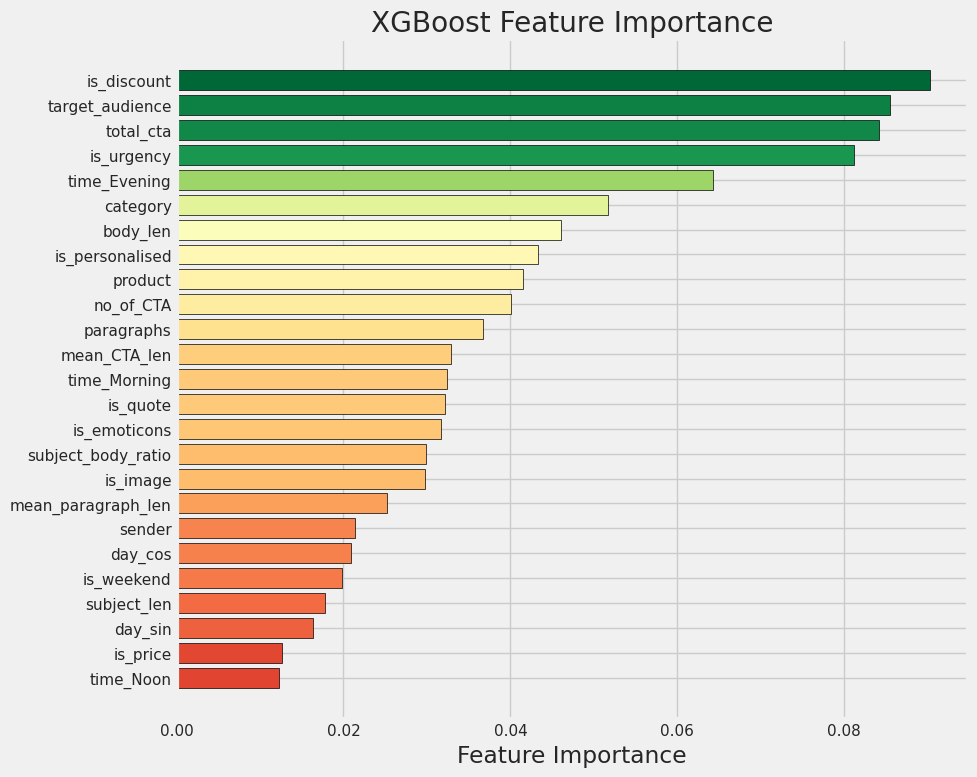


Top 10 wichtigste Features:

   1. is_discount               0.0903
   2. target_audience           0.0855
   3. total_cta                 0.0842
   4. is_urgency                0.0812
   5. time_Evening              0.0642
   6. category                  0.0517
   7. body_len                  0.0461
   8. is_personalised           0.0433
   9. product                   0.0415
  10. no_of_CTA                 0.0401


In [ ]:
# Feature Importance des finalen XGBoost-Modells
feature_names = X_dev.columns.tolist()
importance = final_xgb_model.feature_importances_

# DataFrame erstellen und sortieren
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=True)

# Visualisierung
plt.figure(figsize=(10, 8))

colors = plt.cm.RdYlGn(importance_df['Importance'] / importance_df['Importance'].max())

plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors, edgecolor='black', linewidth=0.5)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Top 10 Features ausgeben
print("\nTop 10 wichtigste Features:\n")
top_10 = importance_df.tail(10).iloc[::-1]
for i, (_, row) in enumerate(top_10.iterrows(), 1):
    print(f"  {i:2}. {row['Feature']:25} {row['Importance']:.4f}")
